## Problem 1-Lighthouse

We have a lighthouse on the shore. It's position is at coordinates $(\alpha,\beta)$ it sends out light uniformly in all directions. The data given is the recordings of the light on the shore. We need to estimate the position of the light shore using this data.

\begin{align}
p(x_{k}| \alpha , \beta) &= \frac{\beta}{\pi (\beta^2 + (x_{k}-\alpha)^2)}\\
prior(\alpha) &= U(0,70)\\
prior(\beta) &= U(0,70)
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
from bilby.core.likelihood import Analytical1DLikelihood
dlhouse = np.loadtxt('/home/abhi/Projects/Bilby/PSet4 Data/data_lighthouse_problem.dat')

In [2]:
class Lorentzlikelihood(bilby.Likelihood):
    def __init__(self, data):
        
        super().__init__(parameters={'alpha': 20, 'beta': 98})
        self.data = data

    def log_likelihood(self):
        d1 = self.data
        alpha = self.parameters['alpha']
        beta = self.parameters['beta']
        res = beta**2 + (d1 - alpha)**2
        return np.sum(np.log(beta)- np.log(res))

likelihood = Lorentzlikelihood(dlhouse)


In [3]:
priors = bilby.core.prior.PriorDict()
priors['alpha']= bilby.prior.Uniform(minimum=0, maximum=70, name='alpha')
priors['beta']= bilby.prior.Uniform(minimum=0, maximum=70, name='beta')


In [6]:
priors.sample()

{'alpha': 6.250400032689868, 'beta': 25.5692491654141}

11:50 bilby INFO    : Running for label 'Lighthouse', output will be saved to 'Lighthouse'
11:50 bilby INFO    : Search parameters:
11:50 bilby INFO    :   alpha = Uniform(minimum=0, maximum=70, name='alpha', latex_label='alpha', unit=None, boundary=None)
11:50 bilby INFO    :   beta = Uniform(minimum=0, maximum=70, name='beta', latex_label='beta', unit=None, boundary=None)
11:50 bilby INFO    : Single likelihood evaluation took 2.088e-04 s


0it [00:00, ?it/s]

11:50 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0513a01a10>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:50 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:50 bilby INFO    : Using dynesty version 1.0.1
11:50 bilby INFO    : Using the bilby-implemented rwalk sampl

1295it [00:22, 48.42it/s, bound:926 nc:101 ncall:1.1e+05 eff:1.2% logz=-1113.36+/-0.44 dlogz:0.101>0.1]  

11:50 bilby INFO    : Written checkpoint file Lighthouse/Lighthouse_resume.pickle
11:50 bilby INFO    : Writing 243 current samples to Lighthouse/Lighthouse_samples.dat
/home/abhi/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1295it [00:23, 54.23it/s, bound:926 nc:  1 ncall:1.1e+05 eff:1.3% logz=-1113.26+/-0.44 dlogz:0.001>0.1]

11:50 bilby INFO    : Sampling time: 0:00:22.321877
11:50 bilby INFO    : Summary of results:
nsamples: 1395
ln_noise_evidence:    nan
ln_evidence: -1113.263 +/-  0.437
ln_bayes_factor:    nan +/-  0.437



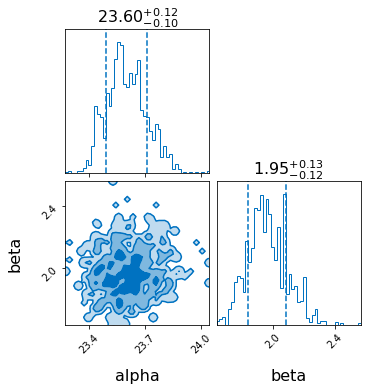

In [16]:
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors,sampler='dynesty',npoints=100, walks=100,
    outdir='Lighthouse',
    label='Lighthouse')
result.plot_corner()

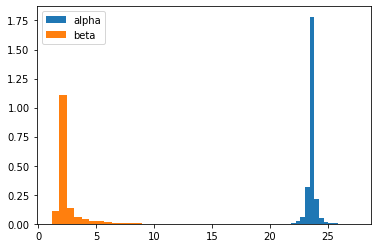

In [9]:
alpha_vals = result.posterior.alpha.values
beta_vals = result.posterior.beta.values

plt.hist(alpha_vals,label='alpha',bins=20,density=True)
plt.hist(beta_vals,label = 'beta' ,bins=20,density=True)
plt.legend()
plt.show()

## Problem 2 - Redshift Count

In this problem we have redshift data of a number of sources with redshift varying between $z=0$ and $z=10$. We also know that the number density depends of redshift as,
\begin{align*}
N(z) = N_0 \frac{1+az}{1+z^3}
\end{align*}

Our task is to estimate $N_0$ and $a$. 

In [10]:
redshift_data = np.loadtxt('/home/abhi/Projects/Bilby/PSet4 Data/data_redshift_problem.dat')

We will now bin the data into a histogram and then get the expected number of sources in each bin.

In [11]:
n_expected,bins = np.histogram(redshift_data,bins = np.linspace(0,10,200))
delta_z = bins[1]-bins[0]

In [12]:
def ndens(z,N,a) :
    x= (1+ a*z)/(1+ z**3)
    y = N*x
    return y 
def ep_num(N,a):
    y = bins[1:]
    x= np.array([ndens(i,N,a)*delta_z for i in y])
    return x

Now the expected number of sources follow a Poisson distribution. 
\begin{equation*}
Prob(z<k_{\text{sources}}<z+\Delta z) = \frac{\lambda(z)^k}{k!} e^{-\lambda(z)}
\end{equation*}

$\lambda(z) = N(z,N_0,a)\times \Delta z$

In [13]:
class p2likelihood(bilby.Likelihood):
    def __init__(self, data):
        
        super().__init__(parameters={'N0': 258, 'a': 16})
        self.data = data

    def log_likelihood(self):
        data = self.data
        N0 = self.parameters['N0']
        a = self.parameters ['a']
        h=np.histogram(data,bins= np.linspace(0,10,200))[0]
        b= np.absolute(ep_num(N0,a))
        d= len(h)
        z=h*np.log(b)- b
        f= np.sum(z)
        return f

l2 = p2likelihood(redshift_data)


In [14]:
prior2 = bilby.core.prior.PriorDict()
prior2['N0']= bilby.prior.Uniform(minimum=0, maximum=1000, name='N0')
prior2['a']= bilby.prior.Uniform(minimum=0, maximum=500, name='a')


11:47 bilby INFO    : Running for label 'Redshift_problem', output will be saved to 'Redshift_problem'
11:47 bilby INFO    : Search parameters:
11:47 bilby INFO    :   N0 = Uniform(minimum=0, maximum=1000, name='N0', latex_label='N0', unit=None, boundary=None)
11:47 bilby INFO    :   a = Uniform(minimum=0, maximum=500, name='a', latex_label='a', unit=None, boundary=None)
11:47 bilby INFO    : Single likelihood evaluation took 1.094e-03 s


0it [00:00, ?it/s]

11:47 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0513f32a50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
11:47 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:47 bilby INFO    : Using dynesty version 1.0.1
11:47 bilby INFO    : Using the bilby-implemented rwalk sampl

1104it [01:04, 10.49it/s, bound:773 nc:101 ncall:2.4e+05 eff:0.5% logz=14525.54+/-0.39 dlogz:0.104>0.1]

11:48 bilby INFO    : Written checkpoint file Redshift_problem/Redshift_problem_resume.pickle
11:48 bilby INFO    : Writing 246 current samples to Redshift_problem/Redshift_problem_samples.dat
/home/abhi/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/abhi/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
11:48 bilby WARNING : Axis limits cannot be NaN or Inf
11:48 bilby WARNING : Failed to create dynesty run plot at checkpoint


1107it [01:06, 16.74it/s, bound:776 nc:  1 ncall:2.4e+05 eff:0.5% logz=14525.63+/-0.39 dlogz:0.001>0.1]

11:48 bilby WARNING : Multiple likelihood matches found between sorted and unsorted samples. Taking the first match.
11:48 bilby INFO    : Sampling time: 0:02:21.025818
11:48 bilby INFO    : Summary of results:
nsamples: 1207
ln_noise_evidence:    nan
ln_evidence: 14525.635 +/-  0.391
ln_bayes_factor:    nan +/-  0.391



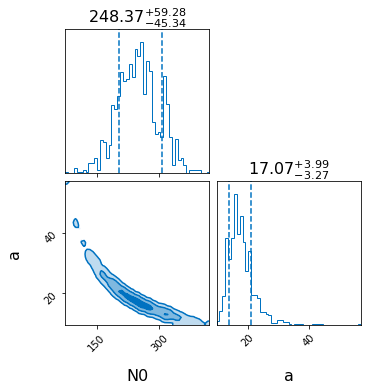

In [15]:
result = bilby.run_sampler(
    likelihood=l2, priors=prior2,sampler='dynesty',npoints=100, walks=100,
    outdir='Redshift_problem',
    label='Redshift_problem')
result.plot_corner()